<a href="https://colab.research.google.com/github/SachinSharma6174/neural_network/blob/main/Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Impact of Pretrained Word Embedding

In [2]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-03-07 15:49:10--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-07 15:49:10--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-07 15:49:11--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:

from keras.datasets import imdb
from sklearn.model_selection import train_test_split

vocab_volume = 4000

(X_train, y_train),  (X_test, y_test) = imdb.load_data(num_words = vocab_volume)
#  70-30 split
train_size = 0.7

x = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

x_train, x_test, y_train, y_test  = train_test_split(x,y,train_size = train_size, random_state = 5999)

print(' training samples, {}'.format(len(x_train) ) )

print(' test samples {} '.format(len(x_test)))
print(' y train samples {} '.format(len(y_train)))
print(' y test samples {} '.format(len(y_test)))


# Retrieve the training sequences.
# (x_train, _), _ = keras.datasets.imdb.load_data()
# Retrieve the word index file mapping words to indices


In [7]:
import keras

word_index = keras.datasets.imdb.get_word_index()
# Reverse the word index to obtain a dict mapping indices to words
inverted_word_index = dict((i, word) for (word, i) in word_index.items())
# Decode the first sequence in the dataset
decoded_sequence = " ".join(inverted_word_index[i] for i in x_train[0])

1654784/1641221 [==============================] - 0s 0us/step


In [9]:
import os
import numpy as np

from keras.layers import Embedding
from keras.initializers import Constant
from keras.layers.recurrent_v2 import GRU
from keras.layers.recurrent import SimpleRNN

from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout


path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

num_tokens = len(word_index)
embedding_dim = 100
hits = 0
misses = 0

# Generating embedding matrix for our word list
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1


model_simple_rnn_Glove = Sequential()
model_simple_rnn_Glove.add(Embedding(num_tokens,embedding_dim,embeddings_initializer=Constant(embedding_matrix), trainable=False))
model_simple_rnn_Glove.add(SimpleRNN(embedding_dim))
model_simple_rnn_Glove.add(Dropout(0.2))
model_simple_rnn_Glove.add(Dense(1, activation='sigmoid'))
model_simple_rnn_Glove.compile(loss='binary_crossentropy', 
                               optimizer='adam', 
                               metrics = ["accuracy"])

Found 400000 word vectors.
Converted 60150 words (28434 misses)


In [11]:
import keras.preprocessing 
from keras.preprocessing import sequence
max_review_words = 650
X_test_pad = sequence.pad_sequences(x_test, maxlen = max_review_words)
X_train_pad = sequence.pad_sequences(x_train, maxlen = max_review_words)

In [12]:
batch_size = 64
number_of_epochs = 4

X_valid, y_valid = X_train_pad[:64], y_train[:64]
X_train2, y_train2 = X_train_pad[64:5000], y_train[64:5000]


model_simple_rnn_Glove.fit(X_train2, y_train2, validation_data=(X_valid, y_valid), epochs=number_of_epochs, batch_size=batch_size )

Epoch 1/4
78/78 [==============================] - 23s 273ms/step - loss: 0.7306 - accuracy: 0.5051 - val_loss: 0.6978 - val_accuracy: 0.5312
Epoch 2/4
78/78 [==============================] - 25s 324ms/step - loss: 0.6896 - accuracy: 0.5634 - val_loss: 0.6536 - val_accuracy: 0.6562
Epoch 3/4
78/78 [==============================] - 23s 291ms/step - loss: 0.6737 - accuracy: 0.5790 - val_loss: 0.6798 - val_accuracy: 0.6250
Epoch 4/4
78/78 [==============================] - 27s 341ms/step - loss: 0.6576 - accuracy: 0.6086 - val_loss: 0.6670 - val_accuracy: 0.6406


In [13]:
scores = model_simple_rnn_Glove.evaluate(X_test_pad, y_test, verbose=0)
print('Test accuracy:', scores)

Test accuracy: [0.6962568759918213, 0.5507333278656006]


In [14]:
from sklearn import metrics

y_predicted = model_simple_rnn_Glove.predict(X_test_pad)
print(metrics.classification_report(y_test,np.round(y_predicted)))

              precision    recall  f1-score   support

           0       0.55      0.61      0.58      7627
           1       0.55      0.49      0.52      7373

    accuracy                           0.55     15000
   macro avg       0.55      0.55      0.55     15000
weighted avg       0.55      0.55      0.55     15000



In [15]:
#7. Confusion Matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def displayConfusionMatrix(y_test , y_predicted, title):
  mat = confusion_matrix(y_test, y_predicted)
  sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False)
  plt.xlabel("True Label")
  plt.ylabel("Predicted Label")
  plt.title(title)

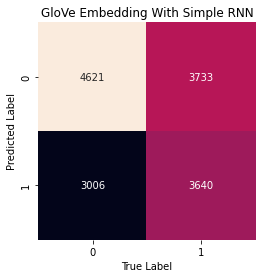

In [16]:
displayConfusionMatrix(y_test=y_test , y_predicted= np.round(y_predicted) , title = "GloVe Embedding With Simple RNN")

In [19]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2022-03-07 16:45:08--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.226.80
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.226.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  53.1MB/s    in 28s     

2022-03-07 16:45:36 (56.1 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [22]:
# gzip -d GoogleNews-vectors-negative300.bin.gz

!gzip -d GoogleNews-vectors-negative300.bin.gz

In [25]:
import gensim
word2vec = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin',binary = True)

In [28]:
num_tokens  = len(word_index)
embedding_dim = 300 
hit = 0
misses = 0

embedding_matrix_word2vec = np.zeros((num_tokens,embedding_dim))

for word, i in word_index.items():
  if word in word2vec:
    embedding_vector = word2vec[word]
    embedding_matrix_word2vec[i] = embedding_vector
    hits+=1
  else:
    misses+=1
print("Hit {} Misses {} ".format(hits,misses))

    



Hit 158298 Misses 39510 


In [29]:
model_simple_rnn_word2vec = Sequential()
model_simple_rnn_word2vec.add(Embedding(num_tokens,embedding_dim,embeddings_initializer=Constant(embedding_matrix_word2vec), trainable=False))
model_simple_rnn_word2vec.add(SimpleRNN(embedding_dim))
model_simple_rnn_word2vec.add(Dropout(0.2))
model_simple_rnn_word2vec.add(Dense(1, activation='sigmoid'))
model_simple_rnn_word2vec.compile(loss='binary_crossentropy', 
                               optimizer='adam', 
                               metrics = ["accuracy"])

In [30]:
batch_size = 64
number_of_epochs = 4

X_valid, y_valid = X_train_pad[:64], y_train[:64]
X_train2, y_train2 = X_train_pad[64:5000], y_train[64:5000]

model_simple_rnn_word2vec.fit(X_train2, y_train2, validation_data=(X_valid, y_valid), epochs=number_of_epochs, batch_size=batch_size )

Epoch 1/4
78/78 [==============================] - 119s 1s/step - loss: 0.7273 - accuracy: 0.5203 - val_loss: 0.7076 - val_accuracy: 0.4844
Epoch 2/4
78/78 [==============================] - 109s 1s/step - loss: 0.7226 - accuracy: 0.5115 - val_loss: 0.6786 - val_accuracy: 0.6406
Epoch 3/4
78/78 [==============================] - 108s 1s/step - loss: 0.7185 - accuracy: 0.5174 - val_loss: 0.6808 - val_accuracy: 0.6094
Epoch 4/4
78/78 [==============================] - 108s 1s/step - loss: 0.7022 - accuracy: 0.5488 - val_loss: 0.6960 - val_accuracy: 0.5156


In [32]:
scores = model_simple_rnn_word2vec.evaluate(X_test_pad, y_test, verbose=0)
print('Test accuracy:', scores)

Test accuracy: [0.7076905965805054, 0.5023333430290222]


In [34]:
from sklearn import metrics

y_predicted = model_simple_rnn_word2vec.predict(X_test_pad)
print(metrics.classification_report(y_test,np.round(y_predicted)))

              precision    recall  f1-score   support

           0       0.62      0.06      0.10      7627
           1       0.50      0.96      0.66      7373

    accuracy                           0.50     15000
   macro avg       0.56      0.51      0.38     15000
weighted avg       0.56      0.50      0.37     15000



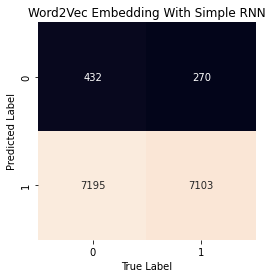

In [35]:
displayConfusionMatrix(y_test=y_test , y_predicted= np.round(y_predicted) , title = "Word2Vec Embedding With Simple RNN")